# Predicting Emotions in Twitter Sentiment Analysis part 1

This data has 1.6 million tweets extracted from Twitter API and it can be found from Kaggle. The data supposedly has positive, neutral and negative sentiment. When examining the data, there is no neutral data. Positive sentiment are labelled as 4 and negative sentiment are labelled are 0. The positive sentiment will be changed to 1 and the negative sentiment remained as 0. The data was gathered using varied emojis of :) and :(. 

Analysing texts from social media is interesting and challenging at the same time due to the frequency of misspellings, slang and sarcasm used.

# Import the data


In [10]:
import spacy
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as r

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

In [2]:
dataset_encoding = 'ISO-8859-1'
columns = ['label', 'ids', 'date', 'flag', 'user', 'text']

data = pd.read_csv('../projects/tweetsdata.csv', encoding = dataset_encoding, names= columns)

In [3]:
data.head()

label         ids                          date      flag             user  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [4]:
data.tail()

label         ids                          date      flag  \
1599995      4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996      4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997      4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998      4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999      4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...

In [5]:
# drop unnecessary columns
data.drop(columns=['flag', 'ids', 'user', 'date'], axis=1, inplace=True)

In [6]:
data['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [7]:
data['label'] = data['label'].replace(4, 1)

In [8]:
data['text'].drop_duplicates(keep=False, inplace=True)

In [9]:
data.count()

label    1600000
text     1600000
dtype: int64

In [10]:
# subsample dataset for first 50,000 data points
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

data_pos = data_pos.iloc[:int(25000)]
data_neg = data_neg.iloc[:int(25000)]

data = pd.concat([data_pos, data_neg])

print(len(data))

50000


In [11]:
data['text'] = data['text'].astype(str)

In [12]:
print('Dataset has %d rows x %d columns.' % ( data.shape[0], data.shape[1]))
print(data.info())
print(data.sample(10))
print('-'* 75)

Dataset has 50000 rows x 2 columns.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 800000 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   text    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
        label                                               text
805919      1  is about to enjoy another German beer... and h...
22966       0                                 i wanna be famous 
17841       0  There's a girl here who looks like Daisy from ...
5110        0  Having some lunch &amp; watching The Women wit...
13200       0  Also, Rivers and Spires will probably be raine...
801977      1  @Willie_Day26 doing this damn outline for a sc...
812058      1  @jimmyfranco pineapple express was fantastic!!...
805324      1  Get paid to advertise your site or affiliate l...
7864        0  New boss looking agitated again today. Been ke...
22

In [13]:
#for c in data.columns:
print('Nulls in dataset:\n',data.isnull().sum())

Nulls in dataset:
 label    0
text     0
dtype: int64


data['text'].nunique()

<AxesSubplot: >

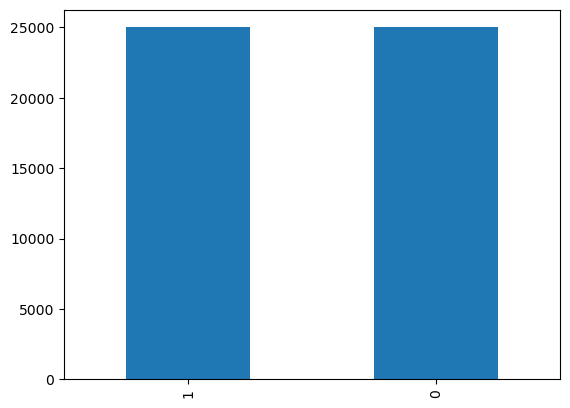

In [14]:
# data is balanced
data['label'].value_counts().plot(kind='bar')

## Preprocessing data

To clean the data, the following steps are taken:
- Spell correction 
- Cleaning of tweet
- Emoticons to text
- Tokenisation
- Stopwords
- Stemming/ lemmatization

### Extraction of emoji into texts 

In [15]:
# custom library for emoticons to text 
SMILEY = {':(': 'sad',
           ':-(': 'sad',
           ':(': 'sad',
          ':)': 'happy',
          ':-)': 'happy',
           ':D': 'happy', 
           '=)': 'happy'
          }

In [16]:
def convert_emoticons(tweet):
    words = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    tweet = ' '.join(reformed)
    
    return tweet

In [17]:
data['text_emoticon'] = data['text'].apply(lambda row: convert_emoticons(row))

In [18]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  
800000        I LOVE @Health4UandPets u guys r the best!!  
800001  im meeting up with one of my besties tonight! ...  
800002  @DaRealSunisaKim Thanks for the Twitter add, S...  
800003  Being sick can be really cheap when it hurts t...  
800004     @LovesBrooklyn2 he has that effect on everyone  
...                                                   ...  
24995   is sad that it is raining... no softball for m...  
24996                               Last day of vacation.  
24997   Good Morning! Its a beautiful day, too bad I'm...  
24998   night all. love yas. hahahahahah btw... vodka ...  
24999       why do i have to go back to school tomorrow??  

[50000 rows x 3 columns]

### clean tweets
data['text_pre'] = data['text'].apply(lambda word: correct_spellings(word) if word is not None else None)
data

In [19]:
def clean_tweet(tweet):
    tweet = re.sub('@([a-zA-Z0-9_]+)', '', tweet)
    tweet = re.sub('#([a-zA-Z0-9_]+)', '', tweet)
    tweet = re.sub('http:\S+', '', tweet)
    # tweet = re.sub('(\w*)[.com$](\s)', '', tweet) # remove extra url
    tweet = re.sub('[^a-zA-Z]', ' ', tweet) # remove non word characters
    tweet = re.sub('[0-9]+', '', tweet) # remove words and digits containing digits
    tweet = re.sub('\s\s+', ' ', tweet)
    #tweet = re.sub(r'([a-z])(.*)\1', r'\1\2', tweet) # clean erpeating chars
    #tweet = re.sub('', '', tweet)
    #tweet = re.sub('', '', tweet)
    
    return tweet

In [20]:
%%time
# clean tweets
data['text_clean'] = data['text_emoticon'].apply(clean_tweet)
data

Wall time: 2.31 s


label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  
800000                          I LOVE u guys r the best   
800001  im meeting up with one of my besties tonight C...  
800002   Thanks for the Twitter add Sunisa I got to me...  
800003  Being sick can be really cheap when it hurts t...  
800004                     he has that effect on everyone  
...                                                   ...  
24995   is sad that it is raining no softball for me t...  
24996                               Last day of vacation   
24997   Good Morning Its a beautiful day too bad I m g...  
24998    night all love yas hahahahahah btw vodka is evil  
24999        why do i have to go back to school tomorrow   

[50000 rows x 4 columns]

In [21]:
data['text_clean'] = data['text_clean'].str.lower()

In [22]:
data['text'].iloc[1]

'im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!'

In [23]:
data['text_clean'].iloc[1]

'im meeting up with one of my besties tonight cant wait girl talk '

In [26]:
data['text_clean'].iloc[10]

'crazy day of school there for hours straiiight about to watch the hills told me too ha happy birthday jb '

### Spell checker 

In [27]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  
800000                          i love u guys r the best   
800001  im meeting up with one of my besties tonight c...  
800002   thanks for the twitter add sunisa i got to me...  
800003  being sick can be really cheap when it hurts t...  
800004                     he has that effect on everyone  
...                                                   ...  
24995   is sad that it is raining no softball for me t...  
24996                               last day of vacation   
24997   good morning its a beautiful day too bad i m g...  
24998    night all love yas hahahahahah btw vodka is evil  
24999        why do i have to go back to school tomorrow   

[50000 rows x 4 columns]

In [28]:
# spelling correction using spellchecker
spell = Speller()

def spell_autocorrect(text):
    correct_spell_words = []
    # initialize Speller object for english language with 'en'
    spell_corrector = Speller(lang='en')
    
    for word in word_tokenize(text):
        # correct spell word
        correct_word = spell_corrector(word)
        correct_spell_words.append(correct_word)

    correct_spelling = ' '.join(correct_spell_words)
    return correct_spelling

In [29]:
data['text_pre'] = data['text_clean'].apply(lambda row: spell_autocorrect(row))

In [30]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  
800000                           i love u guys r the best  
800001  im meeting up with one of my besides tonight c...  
800002  thanks for the twitter add punish i got to mee...  
800003  being sick can be really cheap when it hurts t...  
800004                     he has that effect on everyone  
...                                                   ...  
24995   is sad that it is raining no softball for me t...  
24996                                last day of vacation  
24997   good morning its a beautiful day too bad i m g...  
24998    night all love yas hahahahahah btw vodka is evil  
24999         why do i have to go back to school tomorrow  

[50000 rows x 5 columns]

# Extraction using NLTK: tokenise dataset first
tokenizer = RegexpTokenizer('\s+', gaps=True)
data['text_pre'] = data['text_pre'].apply(tokenizer.tokenize)
data['text_pre'].head()

### Removing Stopwords for commonly occuring words

In [32]:
# make a list of english stopwords
stopwords = nltk.corpus.stopwords.words('english')
# extend list with custom stopwords
my_stopwords = ['asdfghjkl', 'asdfasdfasdf', 'sjkdfhasdf', 'asdfghjk']
stopwords.extend(my_stopwords)

In [33]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
# tokenise dataset first
data['text_token'] = data.apply(lambda row: word_tokenize(row['text_pre']), axis=1)

In [35]:
data['text_token']= data['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
data.tail()

label                                               text  \
24995      0  is sad that it is raining... no softball for m...   
24996      0                             Last day of vacation.    
24997      0  Good Morning! Its a beautiful day, too bad I'm...   
24998      0  night all. love yas. hahahahahah btw... vodka ...   
24999      0     why do i have to go back to school tomorrow??    

                                           text_emoticon  \
24995  is sad that it is raining... no softball for m...   
24996                              Last day of vacation.   
24997  Good Morning! Its a beautiful day, too bad I'm...   
24998  night all. love yas. hahahahahah btw... vodka ...   
24999      why do i have to go back to school tomorrow??   

                                              text_clean  \
24995  is sad that it is raining no softball for me t...   
24996                              last day of vacation    
24997  good morning its a beautiful day too bad i m g...   
24998   night all love yas hahahahahah btw vodka is evil   
24999       why do i have to go back to school tomorrow    

                                                text_pre  \
24995  is sad that it is raining no softball for me t...   
24996                               last day of vacation   
24997  good morning its a beautiful day too bad i m g...   
24998   night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow   

                                              text_token  
24995                    [sad, raining, softball, today]  
24996                              [last, day, vacation]  
24997  [good, morning, beautiful, day, bad, gon, na, ...  
24998  [night, love, yas, hahahahahah, btw, vodka, evil]  
24999                       [go, back, school, tomorrow]

In [36]:
# join words together 
data['text_str'] = data['text_token'].apply(lambda x: ' '.join([item for item in x]))

In [37]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  
800000                                 love u guys r best  
800001  im meeting one besides tonight cant wait girl ...  
800002  thanks twitter add punish got meet hin show dc...  
800003  sick really

In [38]:
# after all processing, create a list of all words
all_words = ' '.join([word for word in data['text_str']])

In [39]:
# tokenise all_words
tokenized_words = word_tokenize(all_words)
tokenized_words

['love',
 'u',
 'guys',
 'r',
 'best',
 'im',
 'meeting',
 'one',
 'besides',
 'tonight',
 'cant',
 'wait',
 'girl',
 'talk',
 'thanks',
 'twitter',
 'add',
 'punish',
 'got',
 'meet',
 'hin',
 'show',
 'dc',
 'area',
 'sweetheart',
 'sick',
 'really',
 'cheap',
 'hurts',
 'much',
 'eat',
 'real',
 'food',
 'plus',
 'friends',
 'make',
 'soup',
 'effect',
 'everyone',
 'tell',
 'burst',
 'laughing',
 'really',
 'loud',
 'thanks',
 'making',
 'come',
 'sunk',
 'response',
 'already',
 'find',
 'answer',
 'jealous',
 'hope',
 'great',
 'time',
 'vegas',
 'like',
 'acm',
 'love',
 'show',
 'ah',
 'contrast',
 'mr',
 'fletcher',
 'finally',
 'joining',
 'twitter',
 'responded',
 'stupid',
 'cat',
 'helping',
 'type',
 'forgive',
 'errors',
 'crazy',
 'day',
 'school',
 'hours',
 'straight',
 'watch',
 'hills',
 'told',
 'ha',
 'happy',
 'birthday',
 'jb',
 'forget',
 'two',
 'half',
 'men',
 'love',
 'show',
 'haha',
 'worry',
 'get',
 'hang',
 'least',
 'one',
 'feeling',
 'lost',
 'may',

In [40]:
fdist=FreqDist(tokenized_words)
fdist

FreqDist({'good': 2941, 'day': 2833, 'get': 2521, 'like': 2435, 'go': 2354, 'quot': 2319, 'work': 2302, 'going': 2300, 'today': 2290, 'got': 2233, ...})

In [41]:
fdist.most_common(10)

[('good', 2941),
 ('day', 2833),
 ('get', 2521),
 ('like', 2435),
 ('go', 2354),
 ('quot', 2319),
 ('work', 2302),
 ('going', 2300),
 ('today', 2290),
 ('got', 2233)]

## need this?
data['text_fdist'] = data['text_token'].apply(lambda x: ' '.join([text for text in x if fdist[text] >= 3 ]))

In [42]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  
800000                                 love u guys r best  
800001  im meeting one besides tonight cant wait girl ...  
800002  thanks twitter add punish got meet hin show dc...  
800003  sick really

### Stemming to reduce words to root/ base form
Stemming is used when the meaning of the text does not matter while Lemmatisation is used for question/answers where the meaning of the text matters. Lemmatiastion is time consuming as it scans the entire document. Run both but choose to only go with 1.

from nltk.stem import WordNetLemmatizer

In [46]:
stemmer = nltk.SnowballStemmer("english")

def stem_tweet(data):
    stem_text = ''.join([stemmer.stem(tweet) for tweet in data])
    return stem_text

data['text_stem']= data['text_str'].apply(lambda x: stem_tweet(x))
data['text_stem'].head()

800000                                   love u guys r best
800001    im meeting one besides tonight cant wait girl ...
800002    thanks twitter add punish got meet hin show dc...
800003    sick really cheap hurts much eat real food plu...
800004                                      effect everyone
Name: text_stem, dtype: object

In [47]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  \
800000                                 love u guys r best   
800001  im meeting one besides tonight cant wait girl ...   
800002  thanks twitter add punish got meet hin show dc...   
800003  sick re

### Lemmatization  

In [49]:
lemm = WordNetLemmatizer()

In [50]:
data['text_lemm'] = data['text_str'].apply(lambda x:lemm.lemmatize(x))
data['text_lemm'].head()

800000                                   love u guys r best
800001    im meeting one besides tonight cant wait girl ...
800002    thanks twitter add punish got meet hin show dc...
800003    sick really cheap hurts much eat real food plu...
800004                                      effect everyone
Name: text_lemm, dtype: object

In [51]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  \
800000                                 love u guys r best   
800001  im meeting one besides tonight cant wait girl ...   
800002  thanks twitter add punish got meet hin show dc...   
800003  sick re

In [52]:
# check if the columns are equal
data['is_equal']= (data['text_str']==data['text_lemm'])

In [53]:
data.is_equal.value_counts()

True     49904
False       96
Name: is_equal, dtype: int64

In [54]:
# words lemmatised: 259 
data[data['is_equal'] == False]

label                                            text  \
800149      1         http://twitpic.com/2y2jf - my cupcakes    
801822      1                             is at 98 followers    
801879      1     is now at FILDIAS  http://plurk.com/p/n03es   
802153      1                       @ichristian works for me    
802729      1                   @RussellCrowbar On my skates    
...       ...                                             ...   
23115       0  @djknucklehead What are the nightmares about?    
23218       0                  @leydon There are ads in this    
23309       0                           @Aleey It sucks then    
23501       0                           Has only 2 followers    
24979       0                               @kpy5330 Finals!    

                                        text_emoticon  \
800149         http://twitpic.com/2y2jf - my cupcakes   
801822                             is at 98 followers   
801879     is now at FILDIAS http://plurk.com/p/n03es   
802153                       @ichristian works for me   
802729                   @RussellCrowbar On my skates   
...                                               ...   
23115   @djknucklehead What are the nightmares about?   
23218                   @leydon There are ads in this   
23309                            @Aleey It sucks then   
23501                            Has only 2 followers   
24979                                @kpy5330 Finals!   

                             text_clean                       text_pre  \
800149                      my cupcakes                    my cupcakes   
801822                  is at followers                is at followers   
801879               is now at fildias                is now at indias   
802153                     works for me                   works for me   
802729                     on my skates                   on my skates   
...                                 ...                            ...   
23115    what are the nightmares about   what are the nightmares about   
23218             there are ads in this          there are ads in this   
23309                     it sucks then                  it sucks then   
23501                has only followers             has only followers   
24979                           finals                          finals   

          text_token    text_str   text_stem  text_lemm  is_equal  
800149    [cupcakes]    cupcakes    cupcakes    cupcake     False  
801822   [followers]   followers   followers   follower     False  
801879      [indias]      indias      indias      india     False  
802153       [works]       works       works       work     False  
802729      [skates]      skates      skates      skate     False  
...              ...         ...         ...        ...       ...  
23115   [nightmares]  nightmares  nightmares  nightmare     False  
23218          [ads]         ads         ads         ad     False  
23309        [sucks]       sucks       sucks       suck     False  
23501    [followers]   followers   followers   follower     False  
24979       [finals]      finals      finals      final     False  

[96 rows x 10 columns]

In [55]:
# nothing to lemmatise 
data[data['is_equal'] == True]

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  \
800000                                 love u guys r best   
800001  im meeting one besides tonight cant wait girl ...   
800002  thanks twitter add punish got meet hin show dc...   
800003  sick re

Compared lemmatised and stemmed words, use stemmed text for further testing.

In [57]:
# remove short words less than 2 characters 
data['text_stem'] = data['text_stem'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [58]:
data

label                                               text  \
800000      1       I LOVE @Health4UandPets u guys r the best!!    
800001      1  im meeting up with one of my besties tonight! ...   
800002      1  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003      1  Being sick can be really cheap when it hurts t...   
800004      1    @LovesBrooklyn2 he has that effect on everyone    
...       ...                                                ...   
24995       0  is sad that it is raining... no softball for m...   
24996       0                             Last day of vacation.    
24997       0  Good Morning! Its a beautiful day, too bad I'm...   
24998       0  night all. love yas. hahahahahah btw... vodka ...   
24999       0     why do i have to go back to school tomorrow??    

                                            text_emoticon  \
800000        I LOVE @Health4UandPets u guys r the best!!   
800001  im meeting up with one of my besties tonight! ...   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003  Being sick can be really cheap when it hurts t...   
800004     @LovesBrooklyn2 he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining... no softball for m...   
24996                               Last day of vacation.   
24997   Good Morning! Its a beautiful day, too bad I'm...   
24998   night all. love yas. hahahahahah btw... vodka ...   
24999       why do i have to go back to school tomorrow??   

                                               text_clean  \
800000                          i love u guys r the best    
800001  im meeting up with one of my besties tonight c...   
800002   thanks for the twitter add sunisa i got to me...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                               last day of vacation    
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999        why do i have to go back to school tomorrow    

                                                 text_pre  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besides tonight c...   
800002  thanks for the twitter add punish i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   
...                                                   ...   
24995   is sad that it is raining no softball for me t...   
24996                                last day of vacation   
24997   good morning its a beautiful day too bad i m g...   
24998    night all love yas hahahahahah btw vodka is evil   
24999         why do i have to go back to school tomorrow   

                                               text_token  \
800000                           [love, u, guys, r, best]   
800001  [im, meeting, one, besides, tonight, cant, wai...   
800002  [thanks, twitter, add, punish, got, meet, hin,...   
800003  [sick, really, cheap, hurts, much, eat, real, ...   
800004                                 [effect, everyone]   
...                                                   ...   
24995                     [sad, raining, softball, today]   
24996                               [last, day, vacation]   
24997   [good, morning, beautiful, day, bad, gon, na, ...   
24998   [night, love, yas, hahahahahah, btw, vodka, evil]   
24999                        [go, back, school, tomorrow]   

                                                 text_str  \
800000                                 love u guys r best   
800001  im meeting one besides tonight cant wait girl ...   
800002  thanks twitter add punish got meet hin show dc...   
800003  sick re

#### Save preprocessed data as csv 

In [3]:
data.isnull().sum()

label              0
text               0
text_emoticon      0
text_clean        92
text_pre         107
text_token         0
text_str         254
text_stem        318
text_lemm        254
is_equal           0
dtype: int64

In [4]:
new_data = data[data['text_stem'].notnull()]
new_data

label                                               text  \
0          1       I LOVE @Health4UandPets u guys r the best!!    
1          1  im meeting up with one of my besties tonight! ...   
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...   
3          1  Being sick can be really cheap when it hurts t...   
4          1    @LovesBrooklyn2 he has that effect on everyone    
...      ...                                                ...   
49995      0  is sad that it is raining... no softball for m...   
49996      0                             Last day of vacation.    
49997      0  Good Morning! Its a beautiful day, too bad I'm...   
49998      0  night all. love yas. hahahahahah btw... vodka ...   
49999      0     why do i have to go back to school tomorrow??    

                                           text_emoticon  \
0            I LOVE @Health4UandPets u guys r the best!!   
1      im meeting up with one of my besties tonight! ...   
2      @DaRealSunisaKim Thanks for the Twitter add, S...   
3      Being sick can be really cheap when it hurts t...   
4         @LovesBrooklyn2 he has that effect on everyone   
...                                                  ...   
49995  is sad that it is raining... no softball for m...   
49996                              Last day of vacation.   
49997  Good Morning! Its a beautiful day, too bad I'm...   
49998  night all. love yas. hahahahahah btw... vodka ...   
49999      why do i have to go back to school tomorrow??   

                                              text_clean  \
0                              i love u guys r the best    
1      im meeting up with one of my besties tonight c...   
2       thanks for the twitter add sunisa i got to me...   
3      being sick can be really cheap when it hurts t...   
4                         he has that effect on everyone   
...                                                  ...   
49995  is sad that it is raining no softball for me t...   
49996                              last day of vacation    
49997  good morning its a beautiful day too bad i m g...   
49998   night all love yas hahahahahah btw vodka is evil   
49999       why do i have to go back to school tomorrow    

                                                text_pre  \
0                               i love u guys r the best   
1      im meeting up with one of my besides tonight c...   
2      thanks for the twitter add punish i got to mee...   
3      being sick can be really cheap when it hurts t...   
4                         he has that effect on everyone   
...                                                  ...   
49995  is sad that it is raining no softball for me t...   
49996                               last day of vacation   
49997  good morning its a beautiful day too bad i m g...   
49998   night all love yas hahahahahah btw vodka is evil   
49999        why do i have to go back to school tomorrow   

                                              text_token  \
0                     ['love', 'u', 'guys', 'r', 'best']   
1      ['im', 'meeting', 'one', 'besides', 'tonight',...   
2      ['thanks', 'twitter', 'add', 'punish', 'got', ...   
3      ['sick', 'really', 'cheap', 'hurts', 'much', '...   
4                                 ['effect', 'everyone']   
...                                                  ...   
49995            ['sad', 'raining', 'softball', 'today']   
49996                        ['last', 'day', 'vacation']   
49997  ['good', 'morning', 'beautiful', 'day', 'bad',...   
49998  ['night', 'love', 'yas', 'hahahahahah', 'btw',...   
49999               ['go', 'back', 'school', 'tomorrow']   

                                                text_str  \
0                                     love u guys r best   
1      im meeting one besides tonight cant wait girl ...   
2      thanks twitter add punish got meet hin show dc...   
3      sick really cheap hurts much eat real food plu...   
4                 

In [5]:
data = new_data

In [6]:
data.to_csv('cleanedtweets.csv', index=False)

In [7]:
data = pd.read_csv('../projects/cleanedtweets.csv')

### Understanding the impact of hastags on tweets

In [13]:
def grab_hashtag(x):
    hashtags = []
    # loop over the words in tweets
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
        
    return hashtags

In [14]:
hashtags_neg = grab_hashtag(data['text'][data['label'] == 0])
hashtags_pos = grab_hashtag(data['text'][data['label'] == 1])

In [15]:
# unnesting list
hashtags_neg = sum(hashtags_neg, [])
hashtags_pos = sum(hashtags_pos, [])

In [16]:
hashtags_neg_fd = FreqDist(hashtags_neg)
hnfd = pd.DataFrame({'Hashtag': list(hashtags_neg_fd.keys()),
                    'Count': list(hashtags_neg_fd.values())})

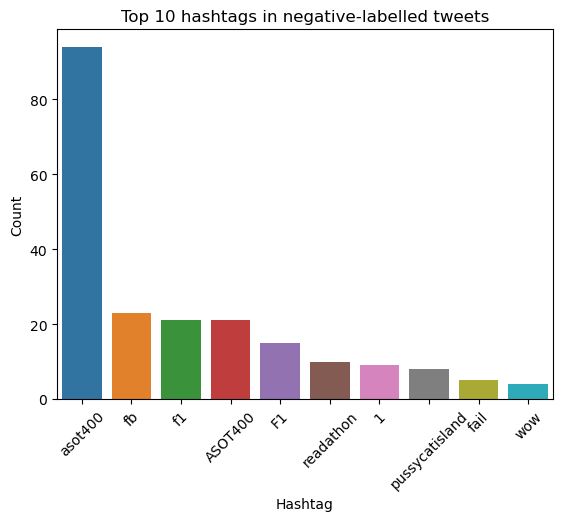

In [17]:
# select top 10 hashtag in negative tweets for plot
hnfd = hnfd.nlargest(columns='Count', n=10)
ax = sns.barplot(data = hnfd, x = 'Hashtag', y = 'Count')
ax.set(ylabel = 'Count')
ax.set_title('Top 10 hashtags in negative-labelled tweets')
ax.tick_params(axis='x', rotation=45)
plt.show()

In [18]:
hashtags_pos_fd = FreqDist(hashtags_pos)
hnfd1 = pd.DataFrame({'Hashtag': list(hashtags_pos_fd.keys()),
                    'Count': list(hashtags_pos_fd.values())})

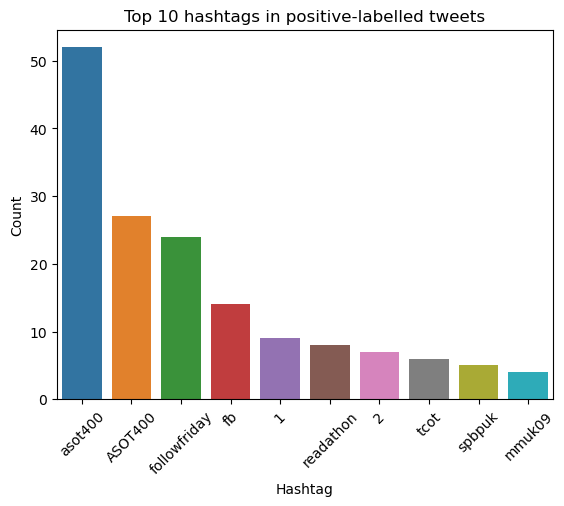

In [19]:
# select top 10 hashtags in positive tweets for plot
hnfd1 = hnfd1.nlargest(columns='Count', n=10)
ax = sns.barplot(data = hnfd1, x = 'Hashtag', y = 'Count')
ax.set(ylabel = 'Count')
ax.set_title('Top 10 hashtags in positive-labelled tweets')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Some visualisations 

In [20]:
from wordcloud import WordCloud

In [21]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [22]:
content_pos = ' '.join(data_pos['text_stem'])
content_pos

'love guys best meeting one besides tonight cant wait girl talk thanks twitter add punish got meet hin show area sweetheart sick really cheap hurts much eat real food plus friends make soup effect everyone tell burst laughing really loud thanks making come sunk response already find answer jealous hope great time vegas like acm love show contrast fletcher finally joining twitter responded stupid cat helping type forgive errors crazy day school hours straight watch hills told happy birthday forget two half men love show haha worry get hang least one feeling lost may cause many later usual nights already addiction make sure post link video lol miss better get permission blessing first added tweet new iphone really know think globe yeah sana gambling para alam din kung makakasama ako picture sweet catching emails rss random back cutting early tonight dinner dancing around room pos jamming ipod getting diary well twitter asked place keeps contest thanks voting anyways going bed goodnight e

In [23]:
tokenize_words = word_tokenize(content_pos)

freqdistpos = FreqDist(tokenize_words)

fdp = pd.DataFrame(freqdistpos.most_common(10), 
                 columns = ['Word', 'Frequency']).drop([0]).reindex()

import plotly.express as px

# top words in whole dataframe
fig = px.bar(fdp, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(255,252,132)',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, opacity=0.8)
fig.show()

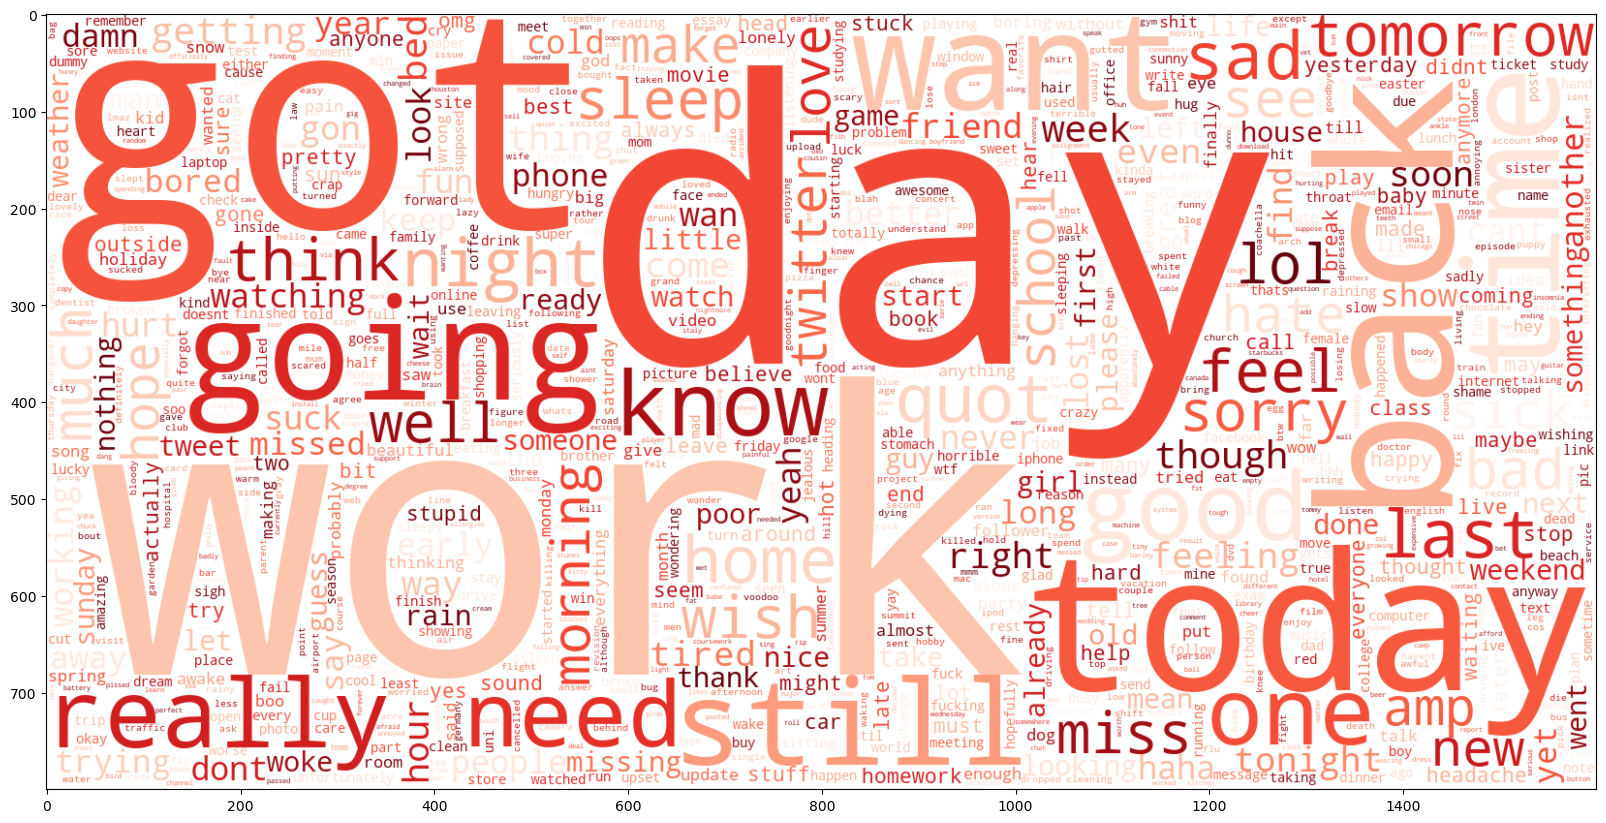

In [26]:
# plot top negative words 
data_neg = data[data.label==0]
data_neg_words = ' '.join([word for word in data_neg['text_stem']])
plt.figure(figsize = (20,20))
wc = WordCloud(colormap='Reds', background_color='white', max_words = 1000 , width = 1600 , height = 800,
               random_state = 42, collocations=False).generate(data_neg_words)
plt.imshow(wc, interpolation = 'bilinear')

In [27]:
content_neg = ' '.join(data_neg['text_stem'])
content_neg

'www summer got david carr third day upset update facebook texting might cry result school today also blah dived many times ball managed save rest bounds whole body feels itch like fire behaving mad see whole crew need hug hey long time see yes rains bit bit lol fine thanks note que mura spring break plain city showing pierced ears bear watch thought loss embarrassing counts either never talk anymore would first gun really though zac snyder doucheclown wish got watch miss premiere mollis death scene hurt severely watch film wry directors cut file taxes ive always wanted see rent love soundtrack dear drinking forgotten table drinks day get much done one friend called asked meet mid valley today time sigh baked cake aged week going hoped blah class tomorrow hate call wake people going cry sleep watching barley sad miss silly tooth lol leslie leslie get mad meh almost lover exception track gets depressed every time hacked account aim make new one want promote gear groove unfortunately rid

In [28]:
# plot negative 
tokenize_words = word_tokenize(content_neg)

freqdistneg = FreqDist(tokenize_words)

fdn = pd.DataFrame(freqdistneg.most_common(10), 
                 columns = ['Word', 'Frequency']).drop([0]).reindex()

import plotly.express as px
# top words in whole dataframe
fig = px.bar(fdn, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(255,252,132)',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, opacity=0.8)
fig.show()

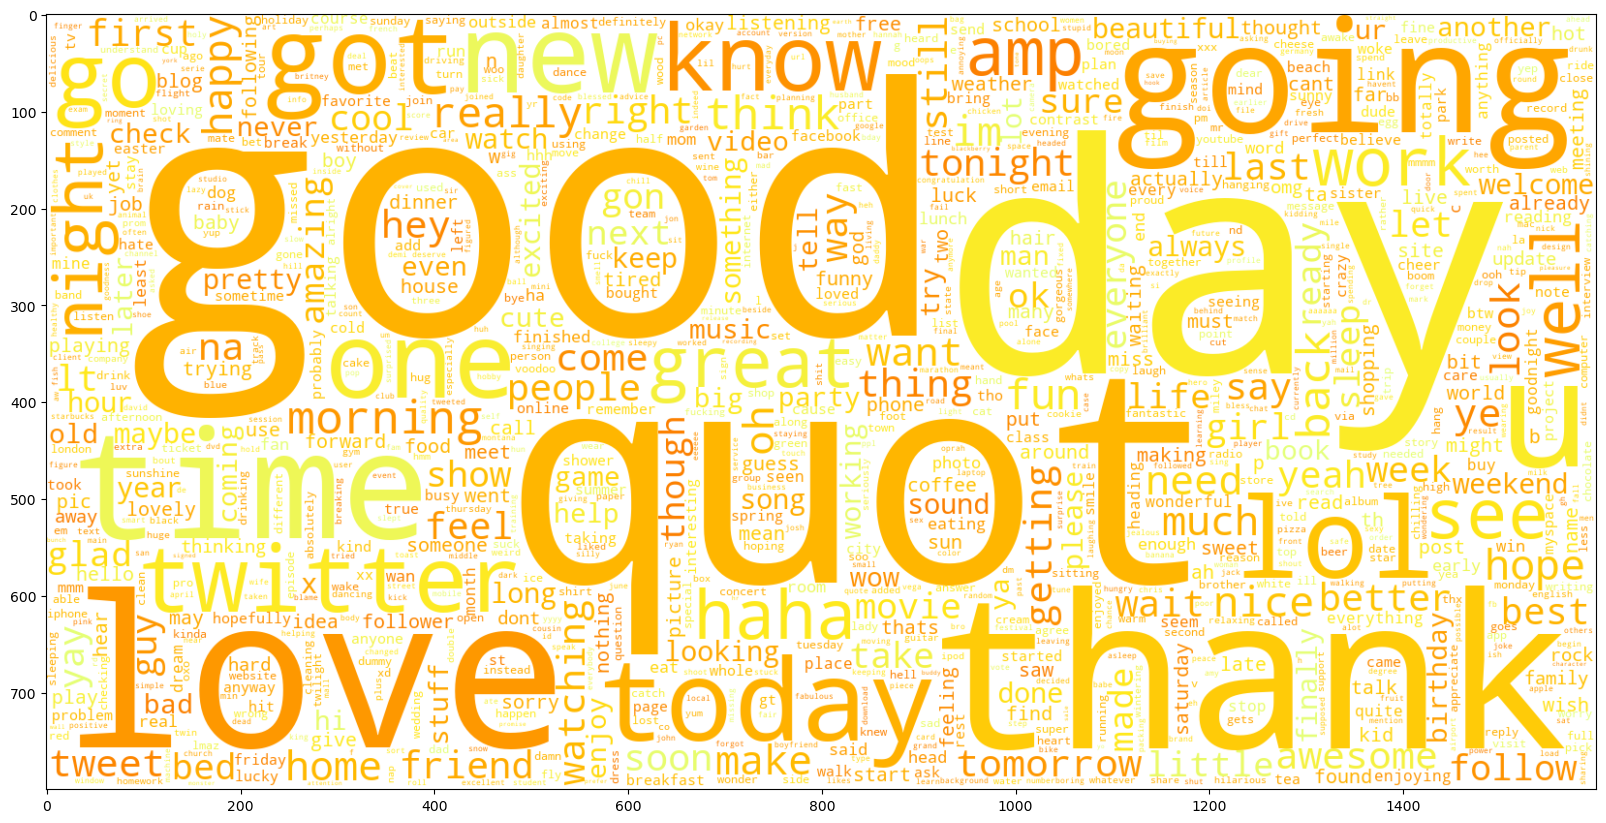

In [30]:
# plot top positive words 
data_pos = data[data.label==1]
data_pos_words = ' '.join([word for word in data_pos['text_lemm']])
plt.figure(figsize = (20,20))
wc = WordCloud(colormap='Wistia', background_color='white', max_words = 1000 , width = 1600 , height = 800,collocations=False,
              random_state=42).generate(data_pos_words)
plt.imshow(wc, interpolation = 'bilinear')

#### Exploring labelled data with SIA

In [3]:
data = pd.read_csv('../projects/cleanedtweets.csv')

In [4]:
data

label                                               text  \
0          1       I LOVE @Health4UandPets u guys r the best!!    
1          1  im meeting up with one of my besties tonight! ...   
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...   
3          1  Being sick can be really cheap when it hurts t...   
4          1    @LovesBrooklyn2 he has that effect on everyone    
...      ...                                                ...   
49677      0  is sad that it is raining... no softball for m...   
49678      0                             Last day of vacation.    
49679      0  Good Morning! Its a beautiful day, too bad I'm...   
49680      0  night all. love yas. hahahahahah btw... vodka ...   
49681      0     why do i have to go back to school tomorrow??    

                                           text_emoticon  \
0            I LOVE @Health4UandPets u guys r the best!!   
1      im meeting up with one of my besties tonight! ...   
2      @DaRealSunisaKim Thanks for the Twitter add, S...   
3      Being sick can be really cheap when it hurts t...   
4         @LovesBrooklyn2 he has that effect on everyone   
...                                                  ...   
49677  is sad that it is raining... no softball for m...   
49678                              Last day of vacation.   
49679  Good Morning! Its a beautiful day, too bad I'm...   
49680  night all. love yas. hahahahahah btw... vodka ...   
49681      why do i have to go back to school tomorrow??   

                                              text_clean  \
0                              i love u guys r the best    
1      im meeting up with one of my besties tonight c...   
2       thanks for the twitter add sunisa i got to me...   
3      being sick can be really cheap when it hurts t...   
4                         he has that effect on everyone   
...                                                  ...   
49677  is sad that it is raining no softball for me t...   
49678                              last day of vacation    
49679  good morning its a beautiful day too bad i m g...   
49680   night all love yas hahahahahah btw vodka is evil   
49681       why do i have to go back to school tomorrow    

                                                text_pre  \
0                               i love u guys r the best   
1      im meeting up with one of my besides tonight c...   
2      thanks for the twitter add punish i got to mee...   
3      being sick can be really cheap when it hurts t...   
4                         he has that effect on everyone   
...                                                  ...   
49677  is sad that it is raining no softball for me t...   
49678                               last day of vacation   
49679  good morning its a beautiful day too bad i m g...   
49680   night all love yas hahahahahah btw vodka is evil   
49681        why do i have to go back to school tomorrow   

                                              text_token  \
0                     ['love', 'u', 'guys', 'r', 'best']   
1      ['im', 'meeting', 'one', 'besides', 'tonight',...   
2      ['thanks', 'twitter', 'add', 'punish', 'got', ...   
3      ['sick', 'really', 'cheap', 'hurts', 'much', '...   
4                                 ['effect', 'everyone']   
...                                                  ...   
49677            ['sad', 'raining', 'softball', 'today']   
49678                        ['last', 'day', 'vacation']   
49679  ['good', 'morning', 'beautiful', 'day', 'bad',...   
49680  ['night', 'love', 'yas', 'hahahahahah', 'btw',...   
49681               ['go', 'back', 'school', 'tomorrow']   

                                                text_str  \
0                                     love u guys r best   
1      im meeting one besides tonight cant wait girl ...   
2      thanks twitter add punish got meet hin show dc...   
3      sick really cheap hurts much eat real food plu...   
4                 

In [5]:
# use vader and compare 
SIA = SentimentIntensityAnalyzer()

In [6]:
data1 = data[['label', 'text', 'text_stem']]
data1

label                                               text  \
0          1       I LOVE @Health4UandPets u guys r the best!!    
1          1  im meeting up with one of my besties tonight! ...   
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...   
3          1  Being sick can be really cheap when it hurts t...   
4          1    @LovesBrooklyn2 he has that effect on everyone    
...      ...                                                ...   
49677      0  is sad that it is raining... no softball for m...   
49678      0                             Last day of vacation.    
49679      0  Good Morning! Its a beautiful day, too bad I'm...   
49680      0  night all. love yas. hahahahahah btw... vodka ...   
49681      0     why do i have to go back to school tomorrow??    

                                               text_stem  
0                                         love guys best  
1        meeting one besides tonight cant wait girl talk  
2      thanks twitter add punish got meet hin show ar...  
3      sick really cheap hurts much eat real food plu...  
4                                        effect everyone  
...                                                  ...  
49677                         sad raining softball today  
49678                                  last day vacation  
49679  good morning beautiful day bad gon spending ma...  
49680          night love yas hahahahahah btw vodka evil  
49681                               back school tomorrow  

[49682 rows x 3 columns]

In [7]:
# Applying Model, Variable Creation
data1['Polarity Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['compound'])
data1['Neutral Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['neu'])
data1['Negative Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['neg'])
data1['Positive Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['pos'])

C:\Users\katel\AppData\Local\Temp\ipykernel_18096\1639943450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Polarity Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['compound'])
C:\Users\katel\AppData\Local\Temp\ipykernel_18096\1639943450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Neutral Score']=data1["text_stem"].apply(lambda x:SIA.polarity_scores(x)['neu'])
C:\Users\katel\AppData\Local\Temp\ipykernel_18096\1639943450.py:4: SettingWithCopyWarning: 
A value is t

In [8]:
# Converting 0 to 1 Decimal Score to a Categorical Variable
data1['Sentiment']=''
data1.loc[data1['Polarity Score']>0,'Sentiment']='Positive'
data1.loc[data1['Polarity Score']==0,'Sentiment']='Neutral'
data1.loc[data1['Polarity Score']<0,'Sentiment']='Negative'

C:\Users\katel\AppData\Local\Temp\ipykernel_18096\3506950883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Sentiment']=''


In [9]:
# new SIA label meanings
data1['SIA_label']=''
data1.loc[data1['Sentiment']=='Positive', 'SIA_label'] = '1'
data1.loc[data1['Sentiment']=='Neutral', 'SIA_label'] = '0'
data1.loc[data1['Sentiment']=='Negative', 'SIA_label'] = '-1'

C:\Users\katel\AppData\Local\Temp\ipykernel_18096\3421927808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['SIA_label']=''


In [14]:
new_sentiment_count = data1.groupby('Sentiment').label.count()
new_sentiment_count

Sentiment
Negative    11772
Neutral     13158
Positive    24752
Name: label, dtype: int64

In [22]:
old_sentiment_count = data.groupby('label').label.count()
old_sentiment_count

label
0    24857
1    24825
Name: label, dtype: int64

In [12]:
data_list = {'Positive': [24825, 24752], 
            'Neutral': [0, 13158], 
             'Negative': [24857, 11772]
            }

label_comparison = pd.DataFrame(data_list, index=['Original count', 
                                                 'SIA_labelled count'])
label_comparison

Positive  Neutral  Negative
Original count         24825        0     24857
SIA_labelled count     24752    13158     11772

Text(0, 0.5, 'Count')

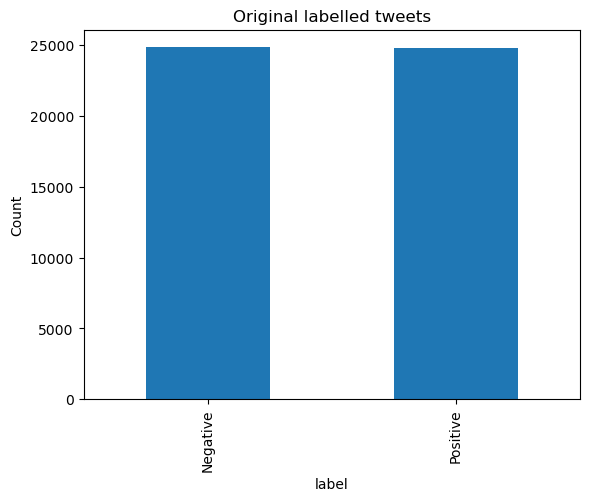

In [24]:
old_sentiment_count.plot(kind='bar')
plt.title('Original labelled tweets')
plt.xticks((0, 1), ('Negative', 'Positive'))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

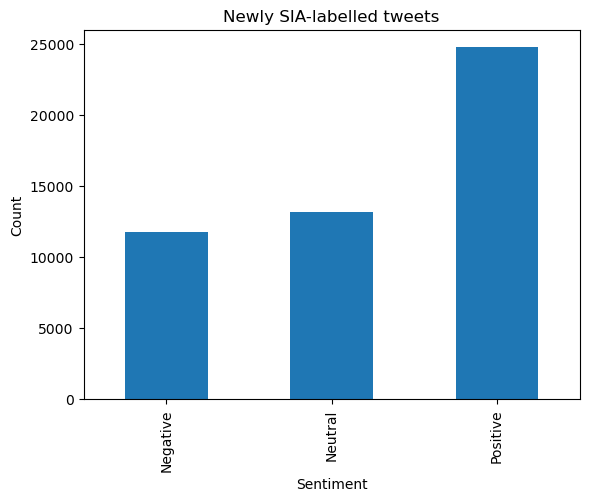

In [20]:
sentiment_count.plot(kind='bar')
plt.title('Newly SIA-labelled tweets')
plt.ylabel('Count')

In [25]:
# have a look at neutral sia-labelled data 
data1[(data1['SIA_label'] == '0')]

label                                               text  \
1          1  im meeting up with one of my besties tonight! ...   
4          1    @LovesBrooklyn2 he has that effect on everyone    
6          1  @r_keith_hill Thans for your response. Ihad al...   
8          1  @tommcfly ah, congrats mr fletcher for finally...   
15         1               Just added tweetie to my new iPhone    
...      ...                                                ...   
49662      0                                  @kpy5330 Finals!    
49663      0  Last day of vacation  I could SO be a stay at ...   
49671      0  thinking of how much i dont wanna go back 2 wo...   
49678      0                             Last day of vacation.    
49681      0     why do i have to go back to school tomorrow??    

                                             text_stem  Polarity Score  \
1      meeting one besides tonight cant wait girl talk             0.0   
4                                      effect everyone             0.0   
6                         response already find answer             0.0   
8            contrast fletcher finally joining twitter             0.0   
15                              added tweet new iphone             0.0   
...                                                ...             ...   
49662                                           finals             0.0   
49663            last day vacation could stay home mom             0.0   
49671          thinking much dont wan back work borrow             0.0   
49678                                last day vacation             0.0   
49681                             back school tomorrow             0.0   

       Neutral Score  Negative Score  Positive Score Sentiment SIA_label  
1                1.0             0.0             0.0   Neutral         0  
4                1.0             0.0             0.0   Neutral         0  
6                1.0             0.0             0.0   Neutral         0  
8                1.0             0.0             0.0   Neutral         0  
15               1.0             0.0             0.0   Neutral         0  
...              ...             ...             ...       ...       ...  
49662            1.0             0.0             0.0   Neutral         0  
49663            1.0             0.0             0.0   Neutral         0  
49671            1.0             0.0             0.0   Neutral         0  
49678            1.0             0.0             0.0   Neutral         0  
49681            1.0             0.0             0.0   Neutral         0  

[13158 rows x 9 columns]

In [26]:
# have a look at pos sia-labelled data 
data1[(data1['SIA_label'] == '1')]

label                                               text  \
0          1       I LOVE @Health4UandPets u guys r the best!!    
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...   
5          1  @ProductOfFear You can tell him that I just bu...   
7          1  @KeepinUpWKris I am so jealous, hope you had a...   
10         1  crazy day of school. there for 10 hours straii...   
...      ...                                                ...   
49670      0  @neenaw Pity he wasn't a bit hot with the ball...   
49674      0  had a really scary dream now i can't fall back...   
49675      0  Fizzy pop league here we come... thanks to you...   
49676      0                         does not want to go back.    
49679      0  Good Morning! Its a beautiful day, too bad I'm...   

                                               text_stem  Polarity Score  \
0                                         love guys best          0.8555   
2      thanks twitter add punish got meet hin show ar...          0.5859   
5      tell burst laughing really loud thanks making ...          0.7490   
7       jealous hope great time vegas like acm love show          0.8934   
10     crazy day school hours straight watch hills to...          0.4939   
...                                                  ...             ...   
49670              pity bit hot ball championship reckon          0.1779   
49674  really scary dream fall back asleep hope come ...          0.5401   
49675                fuzzy pop league come thanks ashley          0.4404   
49676                                          want back          0.0772   
49679  good morning beautiful day bad gon spending ma...          0.5106   

       Neutral Score  Negative Score  Positive Score Sentiment SIA_label  
0              0.106           0.000           0.894  Positive         1  
2              0.398           0.193           0.409  Positive         1  
5              0.523           0.000           0.477  Positive         1  
7              0.193           0.145           0.662  Positive         1  
10             0.467           0.160           0.373  Positive         1  
...              ...             ...             ...       ...       ...  
49670          0.440           0.242           0.319  Positive         1  
49674          0.304           0.212           0.484  Positive         1  
49675          0.633           0.000           0.367  Positive         1  
49676          0.435           0.000           0.565  Positive         1  
49679          0.405           0.202           0.393  Positive         1  

[24752 rows x 9 columns]

In [44]:
# have a look at neg sia-labelled data 
data1[(data1['SIA_label'] == '-1')]

label                                               text  \
3          1  Being sick can be really cheap when it hurts t...   
9          1  @e4VoIP I RESPONDED  Stupid cat is helping me ...   
13         1  @soundwav2010 At least I won't be the only one...   
18         1  Catching Up on Emails, RSS and Random BACN. Th...   
31         1  finally going to bed!  so tired. Was gonna wat...   
...      ...                                                ...   
49984      0  bored my hand hurts like hell...got my phone t...   
49989      0  just back from surrey havent had internet the ...   
49990      0  Bloody twitter, didn't update any of my tweets...   
49995      0  is sad that it is raining... no softball for m...   
49998      0  night all. love yas. hahahahahah btw... vodka ...   

                                               text_stem  Polarity Score  \
3      sick really cheap hurts much eat real food plu...         -0.5542   
9       responded stupid cat helping type forgive errors         -0.3612   
13     least one feeling lost may cause many later us...         -0.2023   
18     catching emails rss random back cutting early ...         -0.1280   
31         finally going bed tired gon watch hills didnt         -0.4404   
...                                                  ...             ...   
49984  bored hand hurts like hell got phone taken won...         -0.6249   
49989    back surrey havent internet whole weekend tired         -0.4404   
49990                   bloody twitter update tweets wtf         -0.7717   
49995                         sad raining softball today         -0.4767   
49998          night love yas hahahahahah btw vodka evil         -0.0516   

       Neutral Score  Negative Score  Positive Score Sentiment SIA_label  
3              0.479           0.356           0.165  Negative        -1  
9              0.229           0.443           0.328  Negative        -1  
13             0.725           0.167           0.109  Negative        -1  
18             0.842           0.158           0.000  Negative        -1  
31             0.707           0.293           0.000  Negative        -1  
...              ...             ...             ...       ...       ...  
49984          0.311           0.436           0.253  Negative        -1  
49989          0.674           0.326           0.000  Negative        -1  
49990          0.309           0.691           0.000  Negative        -1  
49995          0.492           0.508           0.000  Negative        -1  
49998          0.368           0.324           0.309  Negative        -1  

[11772 rows x 9 columns]